In [3]:
import math

c_dict = {
    4: 64, #8,
    6: 24, #3
}

cidr_max = {
    4: 28,
    6: 48
}

def __get_min_samples(ip_version, mask):

    c= c_dict[ip_version]

    
    if ip_version == 4:
        ipv_max = 32
        min_samples=int(c * math.sqrt( math.pow(2, (ipv_max - mask))))
    elif ip_version == 6:
        ipv_max = 64
        min_samples=int(c * math.sqrt(math.sqrt( math.pow(2, (ipv_max - mask)))))
    else:
        pass

    # TODO für später
    

    # bei v6 doppelte wurzel

    # self.logger.info(f"min samples: {min_samples}")
    return min_samples

for i in range(0, cidr_max[4]):
    print(f"4 {i}:\t{__get_min_samples(6,i)}")

for i in range(0, cidr_max[6]):
    print(f"6 {i}:\t{__get_min_samples(6,i)}")

4 0:	196608
4 1:	165326
4 2:	139022
4 3:	116903
4 4:	98304
4 5:	82663
4 6:	69511
4 7:	58451
4 8:	49152
4 9:	41331
4 10:	34755
4 11:	29225
4 12:	24576
4 13:	20665
4 14:	17377
4 15:	14612
4 16:	12288
4 17:	10332
4 18:	8688
4 19:	7306
4 20:	6144
4 21:	5166
4 22:	4344
4 23:	3653
4 24:	3072
4 25:	2583
4 26:	2172
4 27:	1826
6 0:	196608
6 1:	165326
6 2:	139022
6 3:	116903
6 4:	98304
6 5:	82663
6 6:	69511
6 7:	58451
6 8:	49152
6 9:	41331
6 10:	34755
6 11:	29225
6 12:	24576
6 13:	20665
6 14:	17377
6 15:	14612
6 16:	12288
6 17:	10332
6 18:	8688
6 19:	7306
6 20:	6144
6 21:	5166
6 22:	4344
6 23:	3653
6 24:	3072
6 25:	2583
6 26:	2172
6 27:	1826
6 28:	1536
6 29:	1291
6 30:	1086
6 31:	913
6 32:	768
6 33:	645
6 34:	543
6 35:	456
6 36:	384
6 37:	322
6 38:	271
6 39:	228
6 40:	192
6 41:	161
6 42:	135
6 43:	114
6 44:	96
6 45:	80
6 46:	67
6 47:	57


In [ ]:
from netaddr import IPNetwork, IPAddress
import pytricia
from collections import defaultdict

def join_siblings(ip_version, mask, prange):

    ## check if join would be possible
    if mask == 0:
        print("        join siblings not possible - we are at the root of the tree")
        return None


    nw = IPNetwork(f"{prange}/{mask}")


    #### GET SUPERNET
    nw_supernet=nw.supernet(mask-1)[0]
    supernet_ip=str(nw_supernet).split("/")[0]
    supernet_mask=int(str(nw_supernet).split("/")[1])

    siblings=list(nw_supernet.subnet(mask))
    print(f"join_siblings supernet: {nw_supernet}")
    print(f" siblings: {siblings}")

join_siblings(6,48,"2a05:d018:1::" )

p = pytricia.PyTricia(48)
p.insert("0:0:2::/48","0:0:2::/48",)
p.insert("2a05:d018::/48", "2a05:d018::/48")
p.insert("2a05:d018:8000::/48", "2a05:d018:8000::/48")
p.insert("2a05:d018:1::/48", "2a05:d018:1::/48")


print("lpm: ", list(p))

for i in ["2a05:d018:1::", "2a05:d018:dc0::", "2a05:d018:76c::", "2a05:d018:5::", "2a05:d018:4e8::"]:
    try:
        print(p[i])
    except:
        print(f"prefix not found: {i}")


d = defaultdict(int)
d["0:0:2::/48"] = 5

print(d)
d.pop("0:0:2::/48",)


In [ ]:
from clickhouse_driver import Client

cl = Client('localhost')

query='''
select
    netid_string1,
    --has_smaller_as,
    --has_bigger_as,
    --origins_net1_in_net2,
    --origins_net2_in_net1,
    1
from (
        select
            netid_string1,
            (
                select
                    tuple (
                        groupArray(substring(netid_string, 8)), --ipv4 only.
                        groupArray(mask),
                        groupArray(origin)
                    )
                from
                    ipd.prefix_as__v
                where
                    origin > 0
                    and netid_string <> '::ffff:0.0.0.0'
            ) as prefixdata,
            -- prefixdata.1,
            -- prefixdata.2,
            -- prefixdata.3,
            -- arrayMap(
            --     (netid_string2, mask2) -> isIPAddressInRange(netid_string1, concat(netid_string2, '/', toString(mask2))),
            --     prefixdata.1,
            --     prefixdata.2
            -- ) as mask_net1_in_net2,
            -- arrayMap(
            --     (netid_string2, mask2) -> isIPAddressInRange(netid_string2, concat(netid_string1, '/', toString(mask1))),
            --     prefixdata.1,
            --     prefixdata.2
            -- ) as mask_net2_in_net1,
            -- arrayReduce('sum', mask_net2_in_net1) as has_smaller_as,
            -- arrayReduce('sum', mask_net1_in_net2) as has_bigger_as,
            arrayFilter(
                (_, y) -> y,
                prefixdata.3,
                arrayMap(
                    (netid_string2, mask2) -> isIPAddressInRange(netid_string1, concat(netid_string2, '/', toString(mask2))),
                    prefixdata.1,
                    prefixdata.2
                )
            ) as origins_net1_in_net2,
            arrayFilter(
                (_, y) -> y,
                prefixdata.3,
                arrayMap(
                    (netid_string2, mask2) -> isIPAddressInRange(netid_string2, concat(netid_string1, '/', toString(mask1))),
                    prefixdata.1,
                    prefixdata.2
                )
            ) as origins_net2_in_net1,
            1
        from (
            select
                t as T1,
                netid_string as netid_string1,
                mask as mask1
            from
                ipd.range__time_subnet_ingress__v
            where
                ip_version = 4
                and t = toDateTime('2020-09-08 21:00:00')
                -- and metroHash64(netid_string1) % 8 = 0
            order by
                netid_num
            -- limit 1
        ) as X1
        where
            1
            -- and has_smaller_as + has_bigger_as > 0
            and length(origins_net1_in_net2) + length(origins_net2_in_net1) > 0

)
limit 100
'''

#cl.execute(query)

currently 39.0 minutes done
IPD run: avg: 26.15s; min: 0; max: 72
iteration run: avg: 324.1794871794872s; min: 9s; max: 406s


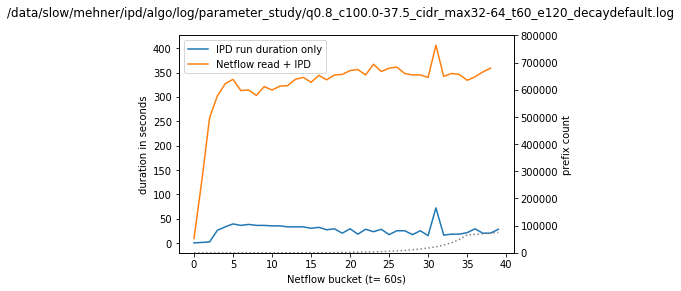

Caution: 2023-02-23 21:50:46.687000 -> 2023-02-24 06:59:01.562000: netflow ts: 1605559320 iteration run took extremly long: 9:08:14.875000
currently 43.0 minutes done
IPD run: avg: 22.204545454545453s; min: 0; max: 44
iteration run: avg: 1058.046511627907s; min: 8s; max: 32894s


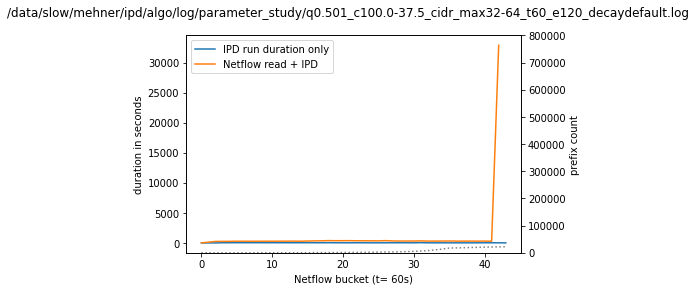

currently 44.0 minutes done
IPD run: avg: 13.733333333333333s; min: 0; max: 44
iteration run: avg: 292.59090909090907s; min: 8s; max: 360s


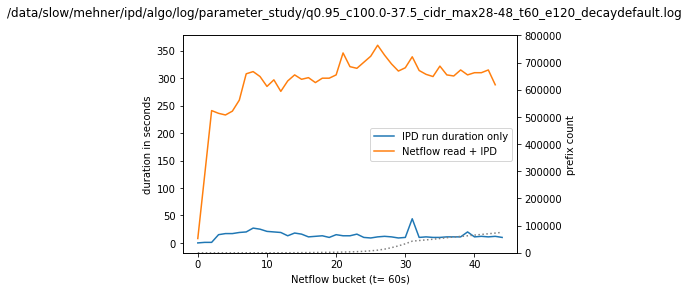

currently 38.0 minutes done
IPD run: avg: 35.333333333333336s; min: 0; max: 138
iteration run: avg: 338.5s; min: 8s; max: 441s


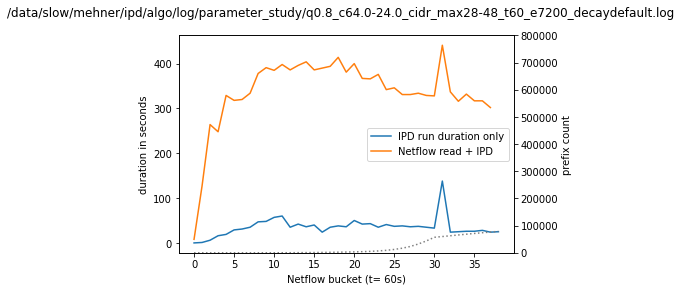

currently 38.0 minutes done
IPD run: avg: 32.76923076923077s; min: 0; max: 74
iteration run: avg: 332.7368421052632s; min: 8s; max: 387s


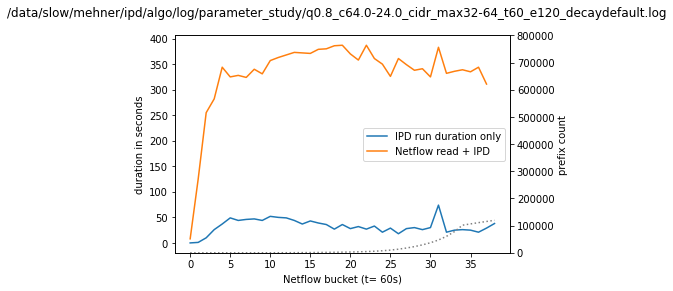

currently 60.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 213.88333333333333s; min: 7s; max: 246s


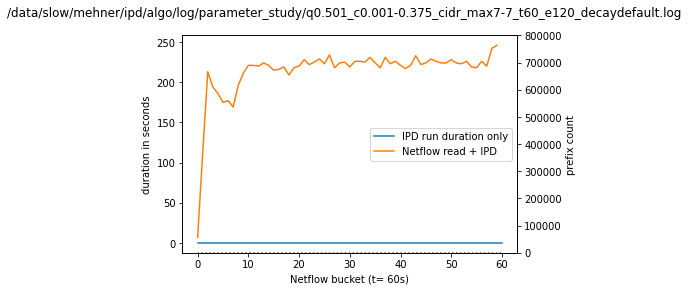

currently 57.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 224.859649122807s; min: 8s; max: 261s


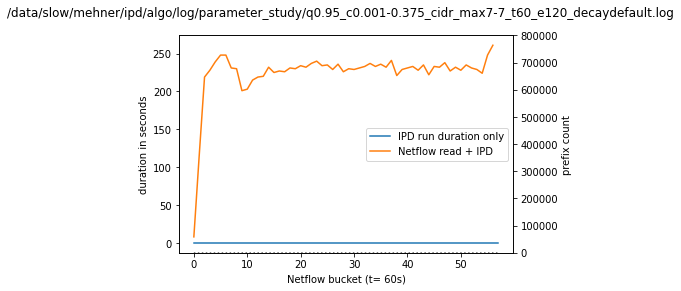

currently 57.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 222.2982456140351s; min: 7s; max: 247s


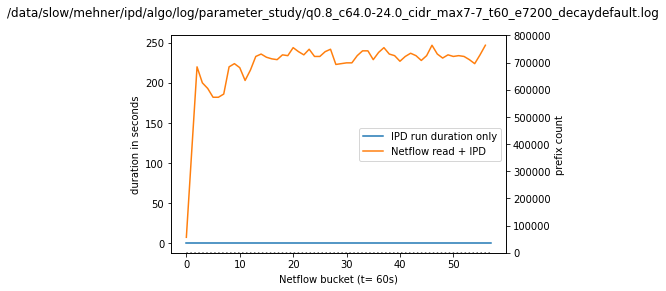

currently 39.0 minutes done
IPD run: avg: 17.775s; min: 0; max: 42
iteration run: avg: 328.28205128205127s; min: 8s; max: 405s


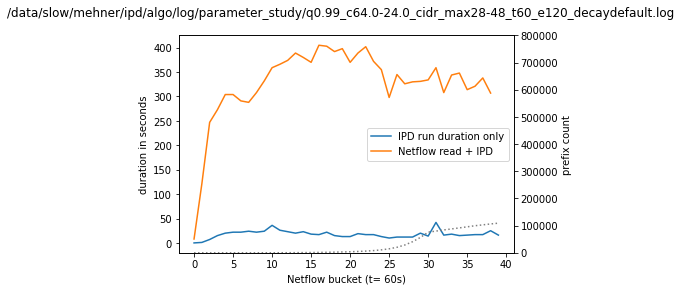

currently 43.0 minutes done
IPD run: avg: 22.886363636363637s; min: 0; max: 108
iteration run: avg: 293.95348837209303s; min: 8s; max: 407s


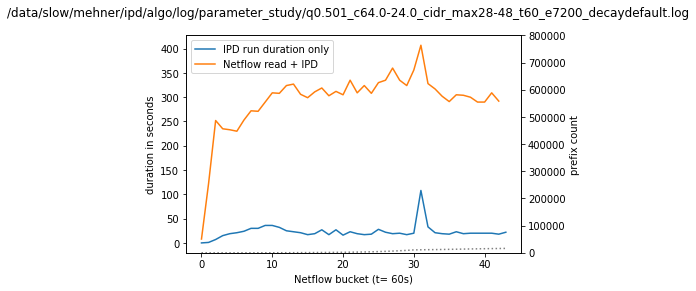

Caution: 2023-02-23 23:28:42.707000 -> 2023-02-24 00:03:52.335000: netflow ts: 1605556740 iteration run took extremly long: 0:35:09.628000
currently 1.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 2109.0s; min: 2109s; max: 2109s


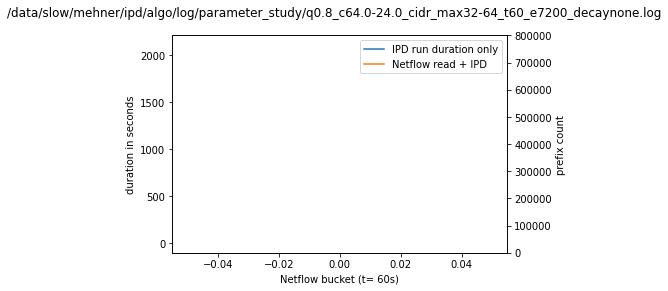

Caution: 2023-02-23 20:25:46.126000 -> 2023-02-23 20:35:55.796000: netflow ts: 1605558240 iteration run took extremly long: 0:10:09.670000
Caution: 2023-02-23 20:35:55.796000 -> 2023-02-23 20:49:21.359000: netflow ts: 1605558300 iteration run took extremly long: 0:13:25.563000
Caution: 2023-02-23 20:49:21.359000 -> 2023-02-23 21:11:05.676000: netflow ts: 1605558360 iteration run took extremly long: 0:21:44.317000
Caution: 2023-02-23 21:11:05.676000 -> 2023-02-23 21:48:44.525000: netflow ts: 1605558420 iteration run took extremly long: 0:37:38.849000
currently 28.0 minutes done
IPD run: avg: 131.85714285714286s; min: 0; max: 1615
iteration run: avg: 446.0357142857143s; min: 9s; max: 2258s


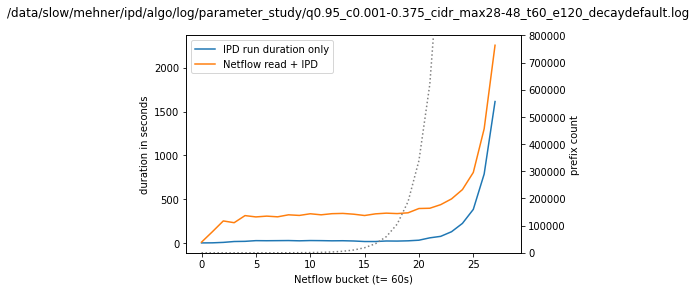

Caution: 2023-02-23 21:03:55.528000 -> 2023-02-23 21:14:14.557000: netflow ts: 1605558660 iteration run took extremly long: 0:10:19.029000
Caution: 2023-02-23 21:14:14.557000 -> 2023-02-23 21:25:15.027000: netflow ts: 1605558720 iteration run took extremly long: 0:11:00.470000
Caution: 2023-02-23 21:25:15.027000 -> 2023-02-23 21:35:37.852000: netflow ts: 1605558780 iteration run took extremly long: 0:10:22.825000
Caution: 2023-02-23 21:35:37.852000 -> 2023-02-23 21:47:36.999000: netflow ts: 1605558840 iteration run took extremly long: 0:11:59.147000
currently 35.0 minutes done
IPD run: avg: 67.52777777777777s; min: 0; max: 318
iteration run: avg: 354.6857142857143s; min: 8s; max: 719s


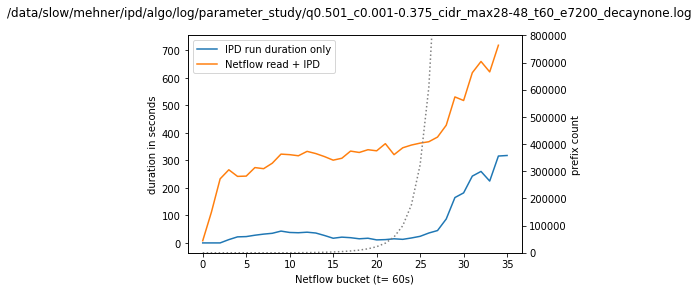

currently 59.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 215.4406779661017s; min: 7s; max: 238s


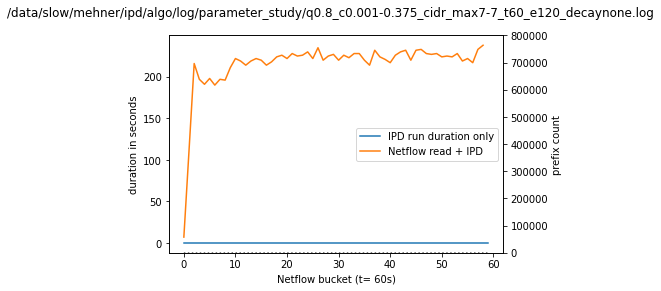

currently 42.0 minutes done
IPD run: avg: 12.395348837209303s; min: 0; max: 34
iteration run: avg: 300.8095238095238s; min: 9s; max: 380s


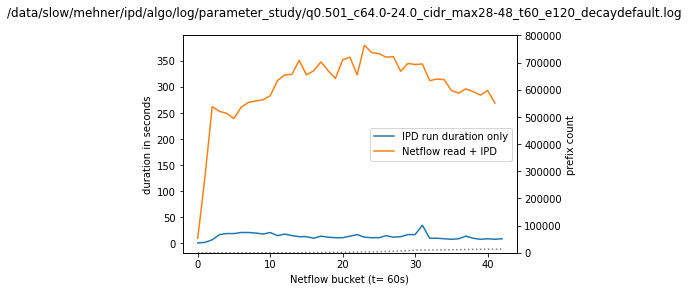

currently 38.0 minutes done
IPD run: avg: 19.28205128205128s; min: 0; max: 47
iteration run: avg: 333.0s; min: 8s; max: 414s


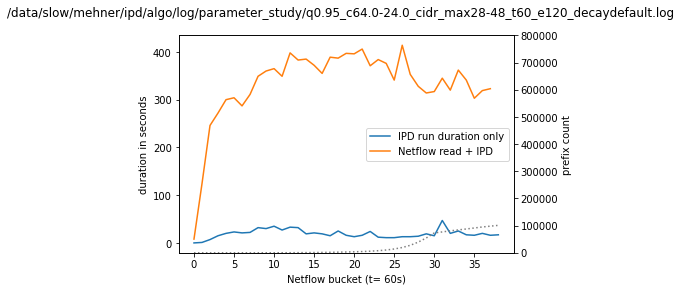

currently 57.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 222.91228070175438s; min: 7s; max: 248s


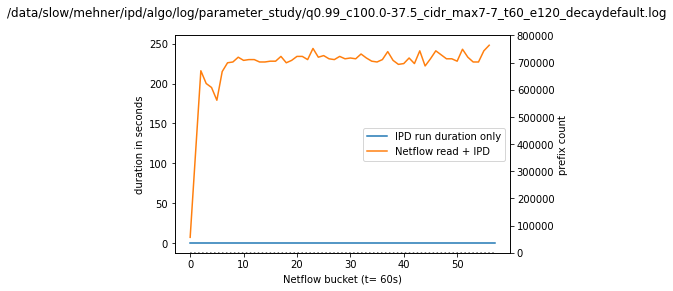

currently 56.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 226.25s; min: 8s; max: 248s


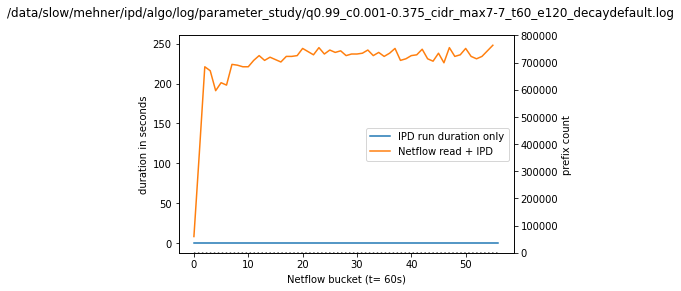

currently 58.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 220.1551724137931s; min: 8s; max: 248s


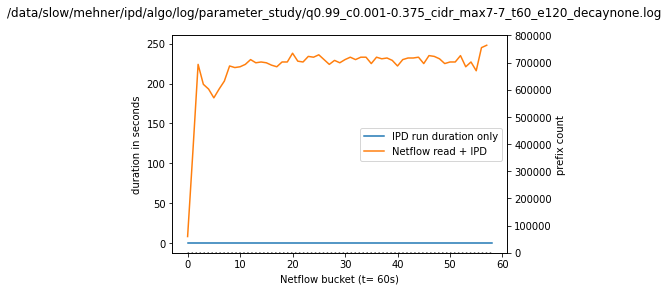

currently 37.0 minutes done
IPD run: avg: 47.73684210526316s; min: 0; max: 162
iteration run: avg: 340.4594594594595s; min: 9s; max: 486s


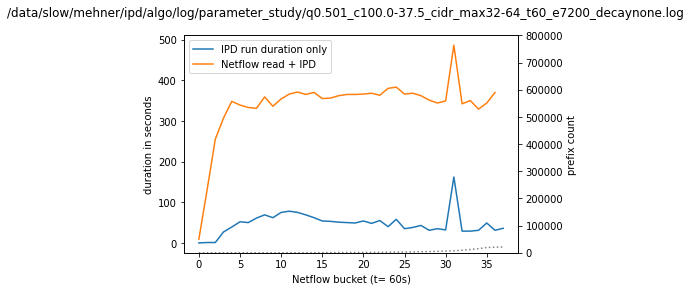

currently 62.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 205.8548387096774s; min: 6s; max: 237s


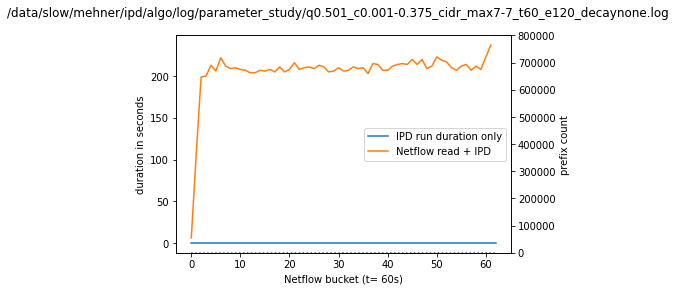

Caution: 2023-02-23 20:50:50.178000 -> 2023-02-23 21:01:16.062000: netflow ts: 1605558240 iteration run took extremly long: 0:10:25.884000
Caution: 2023-02-23 21:01:16.062000 -> 2023-02-23 21:15:05.223000: netflow ts: 1605558300 iteration run took extremly long: 0:13:49.161000
Caution: 2023-02-23 21:15:05.223000 -> 2023-02-23 21:37:30.407000: netflow ts: 1605558360 iteration run took extremly long: 0:22:25.184000
currently 27.0 minutes done
IPD run: avg: 145.21428571428572s; min: 0; max: 1536
iteration run: avg: 437.55555555555554s; min: 8s; max: 1345s


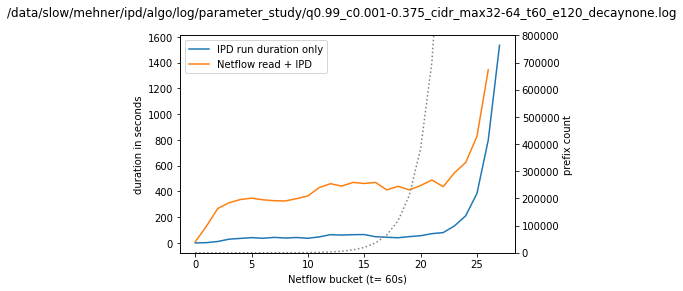

Caution: 2023-02-23 20:44:37.664000 -> 2023-02-23 20:55:11.420000: netflow ts: 1605558300 iteration run took extremly long: 0:10:33.756000
Caution: 2023-02-23 20:55:11.420000 -> 2023-02-23 21:11:18.399000: netflow ts: 1605558360 iteration run took extremly long: 0:16:06.979000
Caution: 2023-02-23 21:11:18.399000 -> 2023-02-23 21:40:19.193000: netflow ts: 1605558420 iteration run took extremly long: 0:29:00.794000
currently 28.0 minutes done
IPD run: avg: 357.9655172413793s; min: 0; max: 6898
iteration run: avg: 427.85714285714283s; min: 9s; max: 1740s


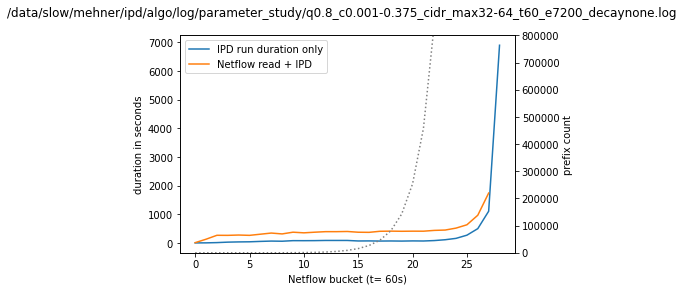

currently 35.0 minutes done
IPD run: avg: 59.611111111111114s; min: 0; max: 144
iteration run: avg: 361.9714285714286s; min: 8s; max: 463s


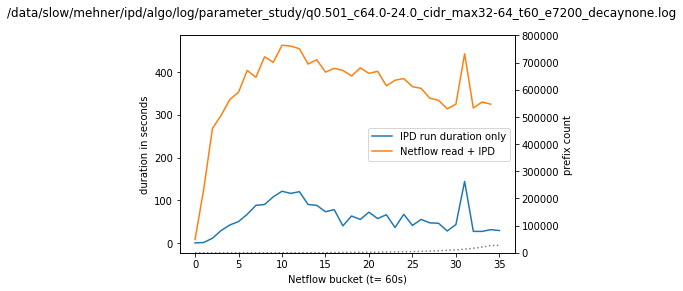

Caution: 2023-02-23 21:16:54.647000 -> 2023-02-23 21:28:08.892000: netflow ts: 1605558600 iteration run took extremly long: 0:11:14.245000
Caution: 2023-02-23 21:28:08.892000 -> 2023-02-23 21:47:51.869000: netflow ts: 1605558660 iteration run took extremly long: 0:19:42.977000
currently 32.0 minutes done
IPD run: avg: 268.8484848484849s; min: 0; max: 6217
iteration run: avg: 388.46875s; min: 9s; max: 1182s


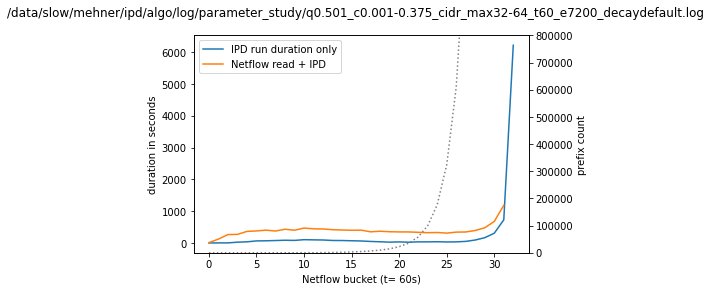

currently 38.0 minutes done
IPD run: avg: 51.743589743589745s; min: 0; max: 164
iteration run: avg: 335.5s; min: 8s; max: 498s


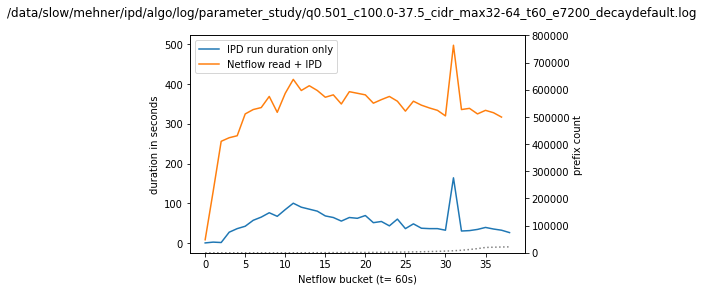

currently 1.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 3.0s; min: 3s; max: 3s


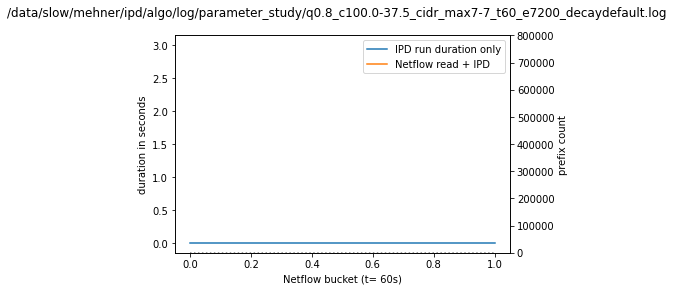

Caution: 2023-02-23 20:51:05.141000 -> 2023-02-23 21:01:35.133000: netflow ts: 1605558240 iteration run took extremly long: 0:10:29.992000
Caution: 2023-02-23 21:01:35.133000 -> 2023-02-23 21:15:54.619000: netflow ts: 1605558300 iteration run took extremly long: 0:14:19.486000
Caution: 2023-02-23 21:15:54.619000 -> 2023-02-23 21:38:21.171000: netflow ts: 1605558360 iteration run took extremly long: 0:22:26.552000
currently 27.0 minutes done
IPD run: avg: 329.5s; min: 0; max: 6689
iteration run: avg: 439.44444444444446s; min: 9s; max: 1346s


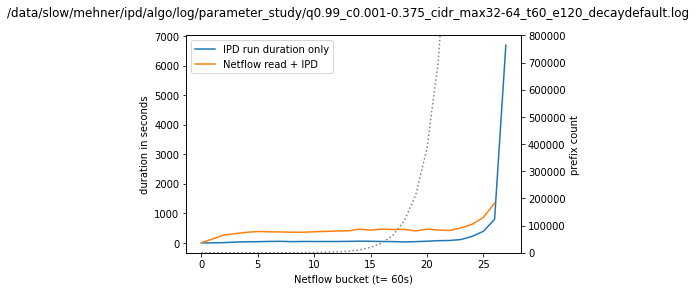

currently 42.0 minutes done
IPD run: avg: 26.0s; min: 0; max: 72
iteration run: avg: 303.0238095238095s; min: 9s; max: 389s


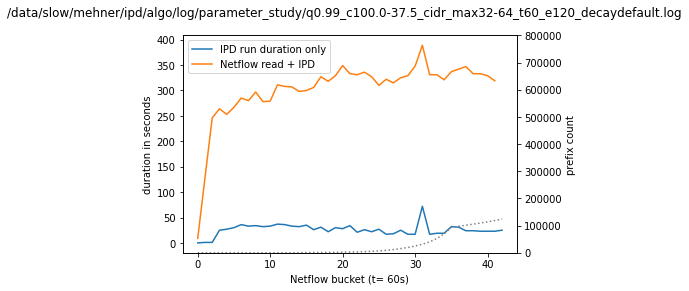

Caution: 2023-02-23 20:53:49.111000 -> 2023-02-23 21:04:40.592000: netflow ts: 1605558300 iteration run took extremly long: 0:10:51.481000
Caution: 2023-02-23 21:04:40.592000 -> 2023-02-23 21:20:54.656000: netflow ts: 1605558360 iteration run took extremly long: 0:16:14.064000
Caution: 2023-02-23 21:20:54.656000 -> 2023-02-23 21:47:13.943000: netflow ts: 1605558420 iteration run took extremly long: 0:26:19.287000
currently 28.0 minutes done
IPD run: avg: 313.41379310344826s; min: 0; max: 6146
iteration run: avg: 442.7857142857143s; min: 9s; max: 1579s


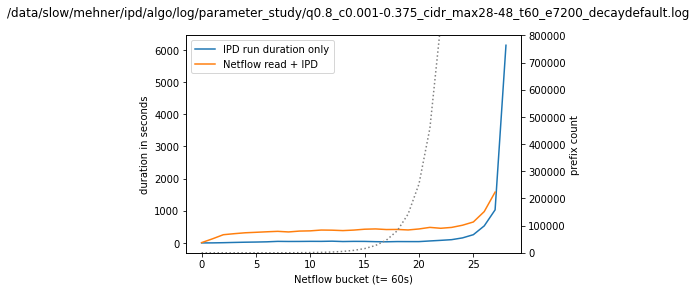

Caution: 2023-02-23 21:02:01.716000 -> 2023-02-23 21:13:08.608000: netflow ts: 1605558600 iteration run took extremly long: 0:11:06.892000
Caution: 2023-02-23 21:13:08.608000 -> 2023-02-23 21:30:29.526000: netflow ts: 1605558660 iteration run took extremly long: 0:17:20.918000
currently 32.0 minutes done
IPD run: avg: 93.51515151515152s; min: 0; max: 1356
iteration run: avg: 356.0s; min: 9s; max: 1040s


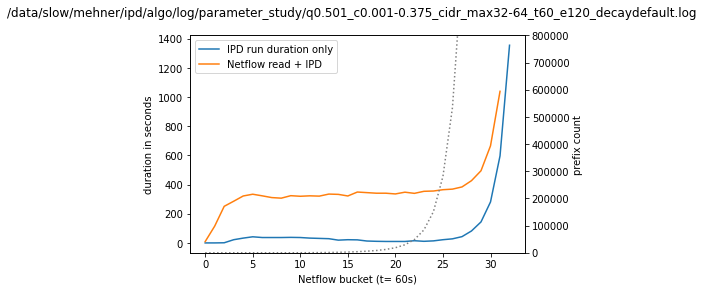

Caution: 2023-02-23 20:30:22.608000 -> 2023-02-23 20:40:58.197000: netflow ts: 1605558300 iteration run took extremly long: 0:10:35.589000
Caution: 2023-02-23 20:40:58.197000 -> 2023-02-23 20:57:26.361000: netflow ts: 1605558360 iteration run took extremly long: 0:16:28.164000
Caution: 2023-02-23 20:57:26.361000 -> 2023-02-23 21:22:37.047000: netflow ts: 1605558420 iteration run took extremly long: 0:25:10.686000
currently 28.0 minutes done
IPD run: avg: 145.3793103448276s; min: 0; max: 1892
iteration run: avg: 390.0357142857143s; min: 9s; max: 1510s


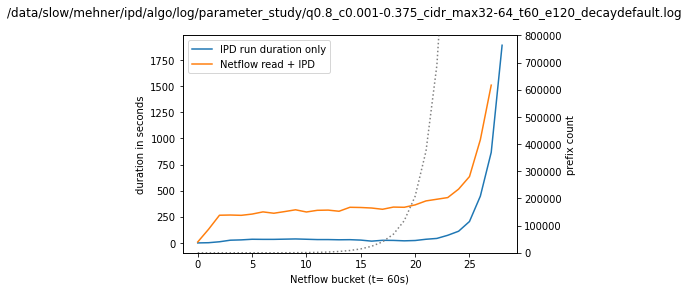

currently 56.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 226.78571428571428s; min: 7s; max: 245s


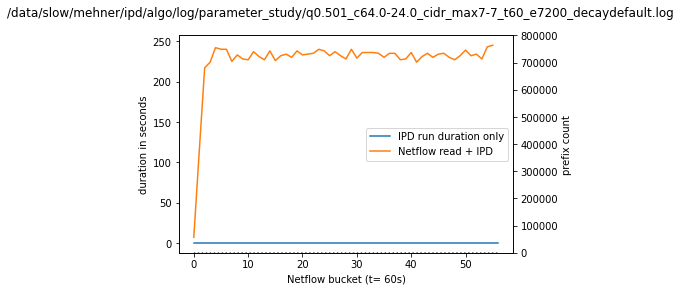

currently 57.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 222.49122807017545s; min: 7s; max: 246s


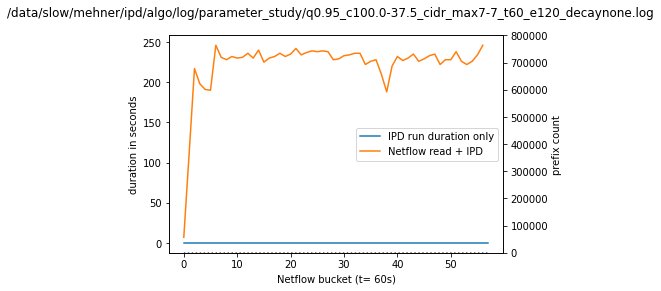

Caution: 2023-02-23 20:31:36.044000 -> 2023-02-23 20:44:29.294000: netflow ts: 1605558300 iteration run took extremly long: 0:12:53.250000
Caution: 2023-02-23 20:44:29.294000 -> 2023-02-23 21:04:56.639000: netflow ts: 1605558360 iteration run took extremly long: 0:20:27.345000
Caution: 2023-02-23 21:04:56.639000 -> 2023-02-23 21:43:21.365000: netflow ts: 1605558420 iteration run took extremly long: 0:38:24.726000
currently 28.0 minutes done
IPD run: avg: 127.53571428571429s; min: 0; max: 1650
iteration run: avg: 434.5s; min: 8s; max: 2304s


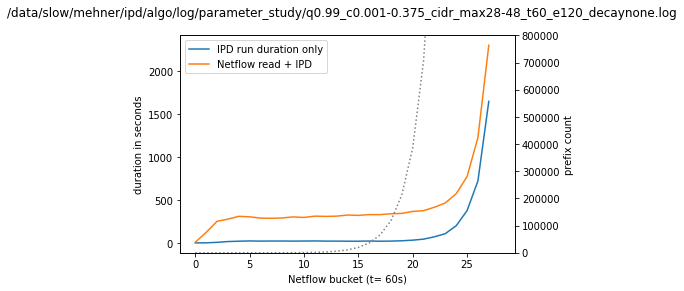

currently 61.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 210.81967213114754s; min: 7s; max: 236s


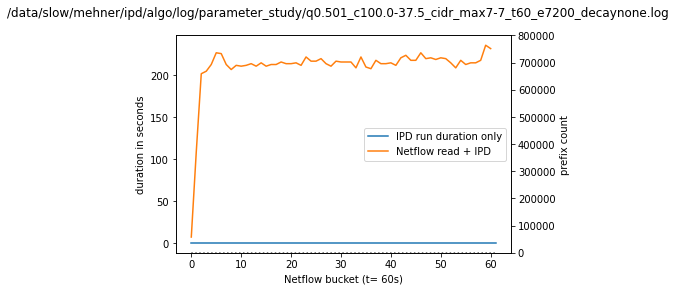

currently 56.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 226.05357142857142s; min: 8s; max: 247s


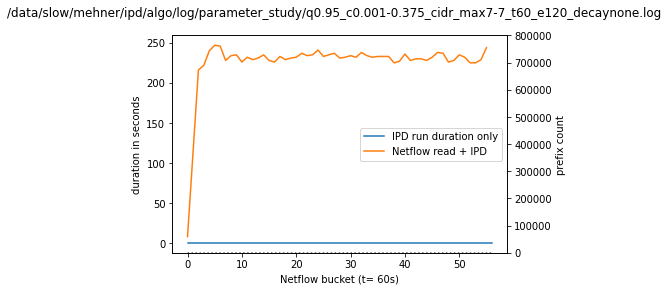

Caution: 2023-02-23 20:24:49.928000 -> 2023-02-23 20:35:05.369000: netflow ts: 1605558240 iteration run took extremly long: 0:10:15.441000
Caution: 2023-02-23 20:35:05.369000 -> 2023-02-23 20:48:09.176000: netflow ts: 1605558300 iteration run took extremly long: 0:13:03.807000
Caution: 2023-02-23 20:48:09.176000 -> 2023-02-23 21:08:47.589000: netflow ts: 1605558360 iteration run took extremly long: 0:20:38.413000
Caution: 2023-02-23 21:08:47.589000 -> 2023-02-23 21:48:12.348000: netflow ts: 1605558420 iteration run took extremly long: 0:39:24.759000
currently 28.0 minutes done
IPD run: avg: 130.53571428571428s; min: 0; max: 1685
iteration run: avg: 444.82142857142856s; min: 8s; max: 2364s


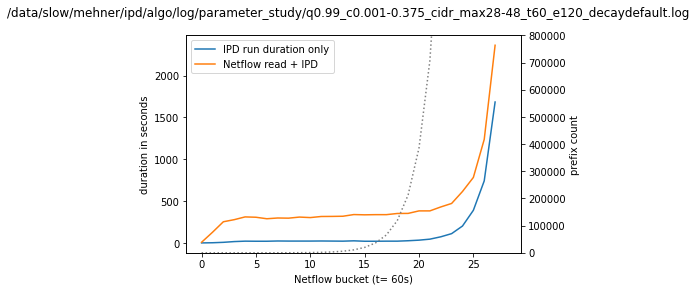

Caution: 2023-02-23 22:00:52.905000 -> 2023-02-23 23:58:52.365000: netflow ts: 1605556740 iteration run took extremly long: 1:57:59.460000
currently 1.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 7079.0s; min: 7079s; max: 7079s


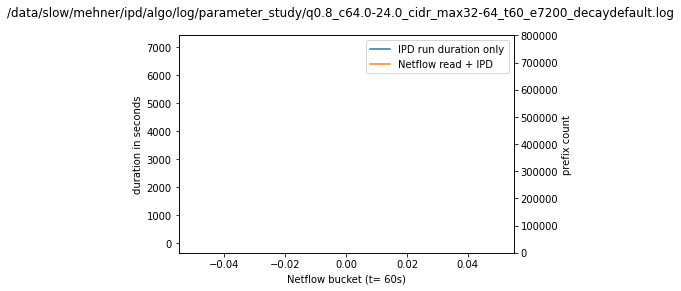

currently 37.0 minutes done
IPD run: avg: 33.078947368421055s; min: 0; max: 71
iteration run: avg: 345.3243243243243s; min: 8s; max: 434s


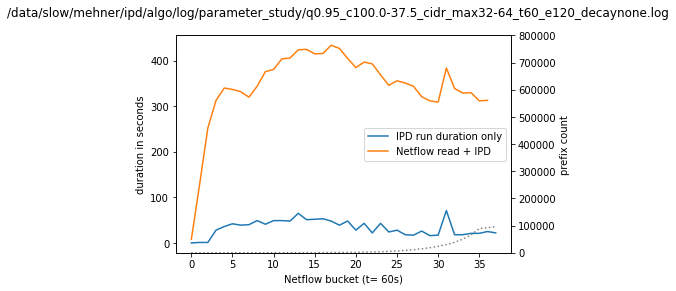

currently 59.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 214.864406779661s; min: 7s; max: 234s


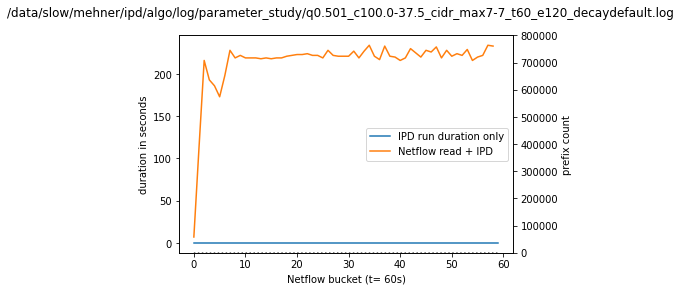

currently 39.0 minutes done
IPD run: avg: 47.0s; min: 0; max: 141
iteration run: avg: 328.79487179487177s; min: 8s; max: 450s


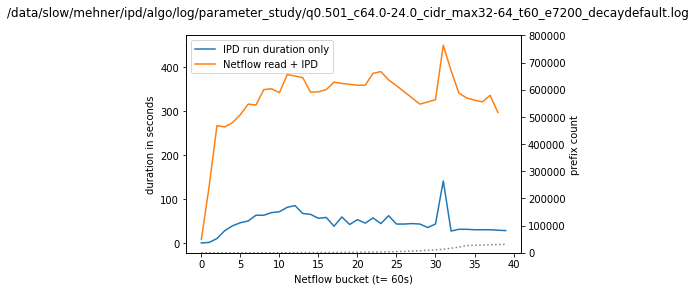

currently 40.0 minutes done
IPD run: avg: 26.195121951219512s; min: 0; max: 58
iteration run: avg: 321.45s; min: 8s; max: 390s


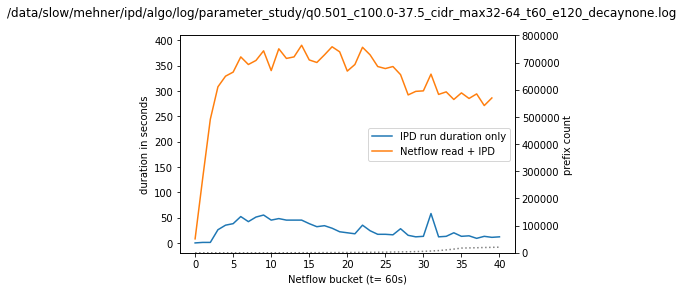

currently 59.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 214.9322033898305s; min: 8s; max: 234s


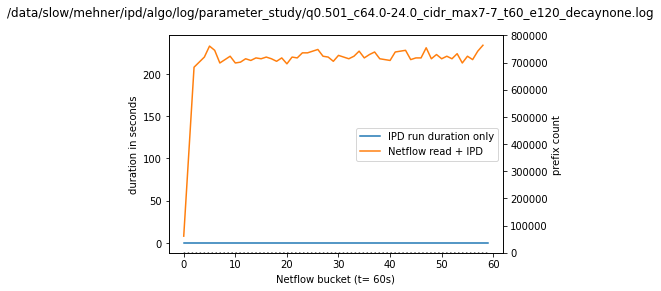

currently 56.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 226.17857142857142s; min: 7s; max: 248s


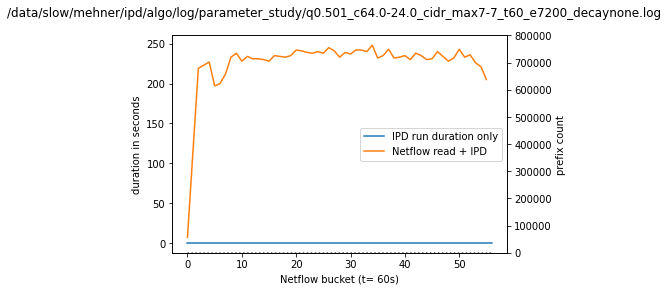

Caution: 2023-02-23 20:36:48.398000 -> 2023-02-23 20:47:23.146000: netflow ts: 1605558300 iteration run took extremly long: 0:10:34.748000
Caution: 2023-02-23 20:47:23.146000 -> 2023-02-23 21:02:22.645000: netflow ts: 1605558360 iteration run took extremly long: 0:14:59.499000
Caution: 2023-02-23 21:02:22.645000 -> 2023-02-23 21:25:43.611000: netflow ts: 1605558420 iteration run took extremly long: 0:23:20.966000
currently 28.0 minutes done
IPD run: avg: 143.75862068965517s; min: 0; max: 1819
iteration run: avg: 396.64285714285717s; min: 9s; max: 1400s


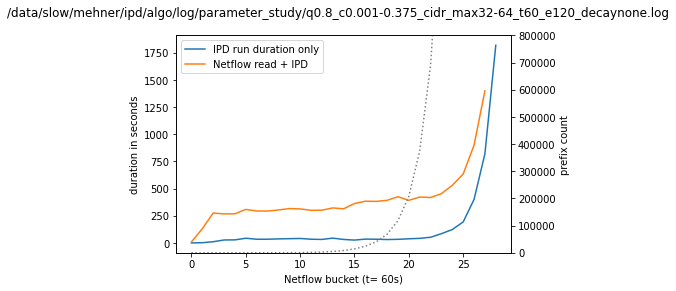

currently 58.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 219.9655172413793s; min: 6s; max: 244s


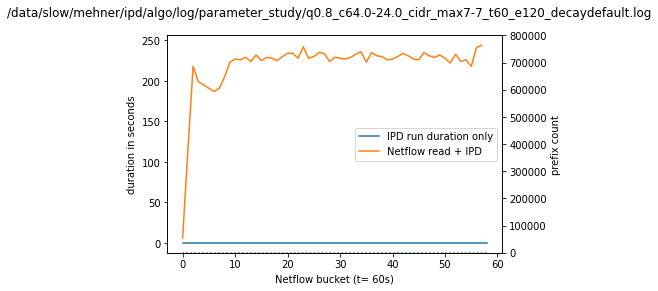

currently 38.0 minutes done
IPD run: avg: 27.82051282051282s; min: 0; max: 73
iteration run: avg: 329.89473684210526s; min: 8s; max: 414s


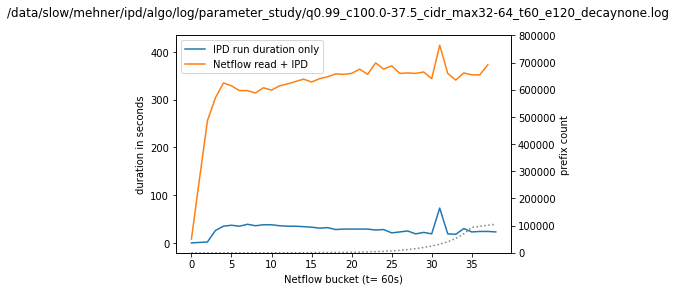

currently 38.0 minutes done
IPD run: avg: 34.58974358974359s; min: 0; max: 72
iteration run: avg: 333.13157894736844s; min: 8s; max: 401s


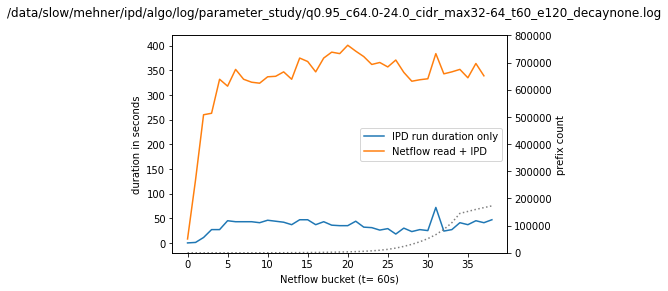

currently 57.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 222.5438596491228s; min: 7s; max: 246s


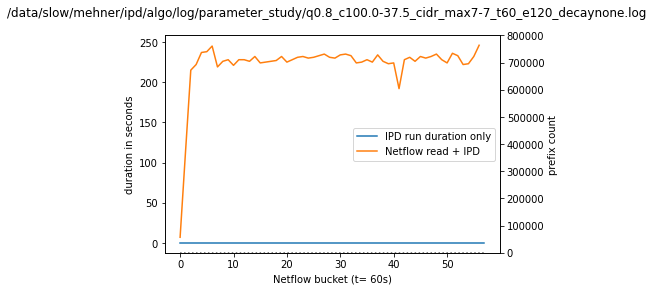

currently 42.0 minutes done
IPD run: avg: 13.953488372093023s; min: 0; max: 37
iteration run: avg: 303.6666666666667s; min: 9s; max: 374s


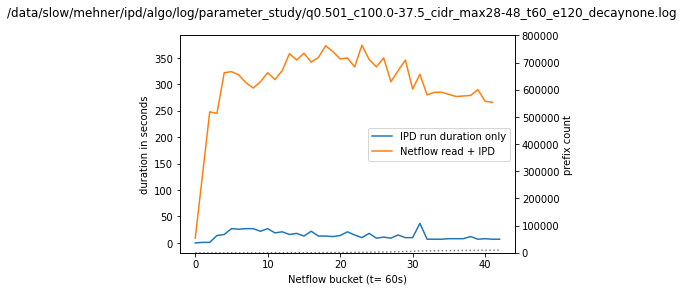

currently 41.0 minutes done
IPD run: avg: 14.023809523809524s; min: 0; max: 46
iteration run: avg: 312.3170731707317s; min: 9s; max: 371s


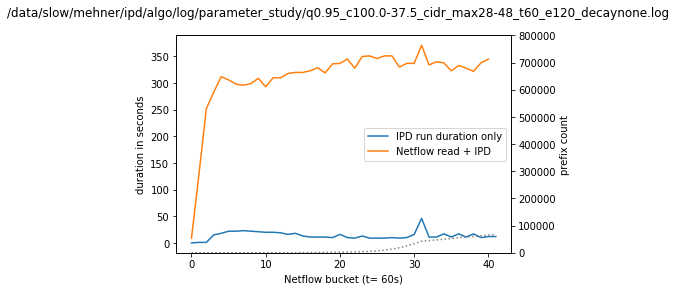

currently 61.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 210.59016393442624s; min: 8s; max: 237s


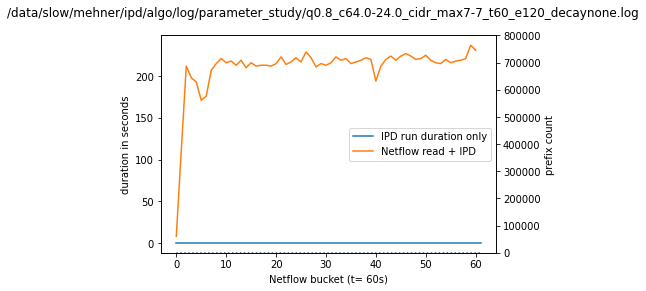

currently 38.0 minutes done
IPD run: avg: 27.53846153846154s; min: 0; max: 146
iteration run: avg: 331.3157894736842s; min: 8s; max: 479s


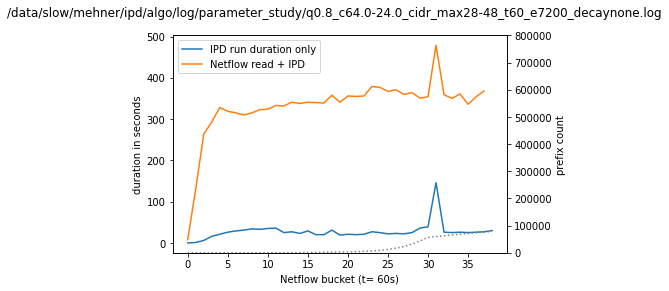

Caution: 2023-02-23 21:16:39.950000 -> 2023-02-23 21:27:56.050000: netflow ts: 1605558600 iteration run took extremly long: 0:11:16.100000
Caution: 2023-02-23 21:27:56.050000 -> 2023-02-23 21:48:21.799000: netflow ts: 1605558660 iteration run took extremly long: 0:20:25.749000
currently 32.0 minutes done
IPD run: avg: 269.45454545454544s; min: 0; max: 6246
iteration run: avg: 389.375s; min: 8s; max: 1225s


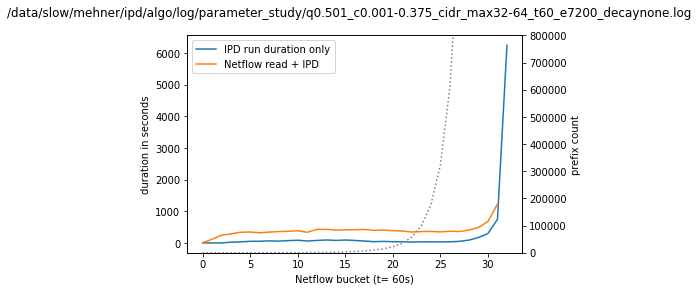

currently 40.0 minutes done
IPD run: avg: 25.0s; min: 0; max: 115
iteration run: avg: 315.625s; min: 9s; max: 420s


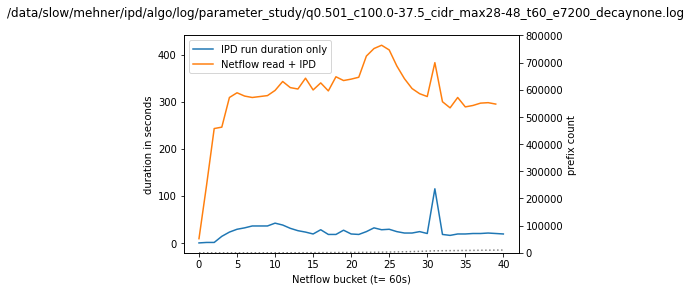

currently 39.0 minutes done
IPD run: avg: 15.775s; min: 0; max: 45
iteration run: avg: 327.3076923076923s; min: 10s; max: 387s


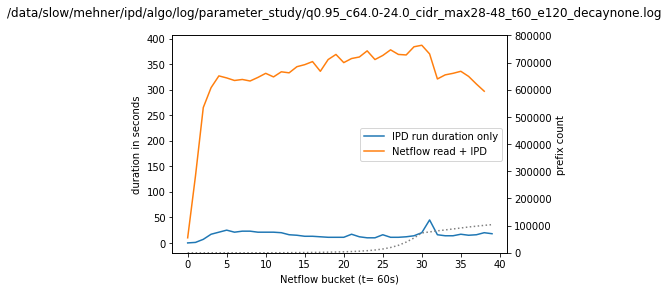

Caution: 2023-02-23 21:37:51.861000 -> 2023-02-23 21:48:34.554000: netflow ts: 1605558840 iteration run took extremly long: 0:10:42.693000
currently 35.0 minutes done
IPD run: avg: 56.27777777777778s; min: 0; max: 259
iteration run: avg: 356.34285714285716s; min: 9s; max: 642s


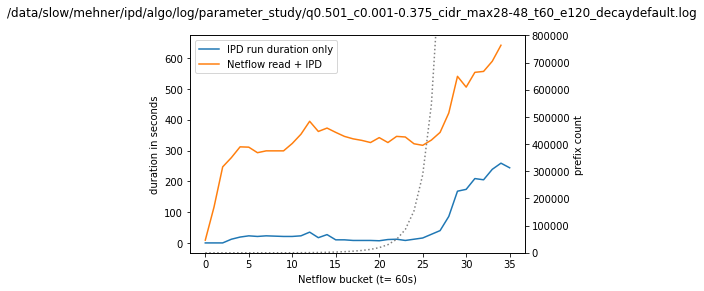

currently 41.0 minutes done
IPD run: avg: 16.166666666666668s; min: 0; max: 40
iteration run: avg: 311.2682926829268s; min: 9s; max: 385s


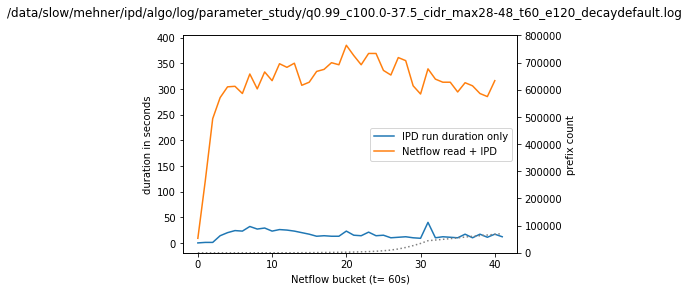

currently 42.0 minutes done
IPD run: avg: 15.953488372093023s; min: 0; max: 58
iteration run: avg: 301.73809523809524s; min: 8s; max: 382s


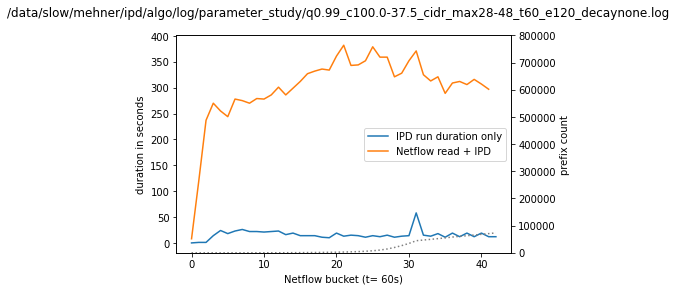

Caution: 2023-02-23 20:33:42.105000 -> 2023-02-23 20:46:50.519000: netflow ts: 1605558360 iteration run took extremly long: 0:13:08.414000
Caution: 2023-02-23 20:46:50.519000 -> 2023-02-23 21:09:40.877000: netflow ts: 1605558420 iteration run took extremly long: 0:22:50.358000
Caution: 2023-02-23 21:09:40.877000 -> 2023-02-23 21:43:45.499000: netflow ts: 1605558480 iteration run took extremly long: 0:34:04.622000
currently 29.0 minutes done
IPD run: avg: 127.96666666666667s; min: 0; max: 1205
iteration run: avg: 420.2758620689655s; min: 8s; max: 2044s


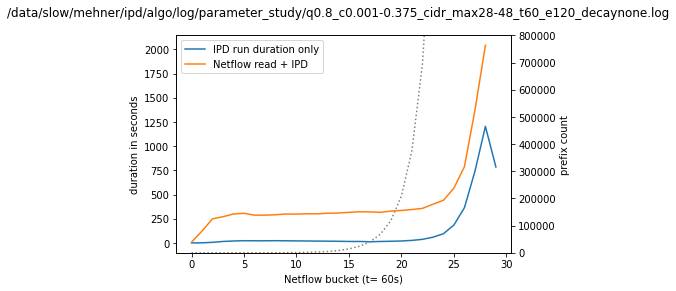

currently 59.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 215.77966101694915s; min: 7s; max: 239s


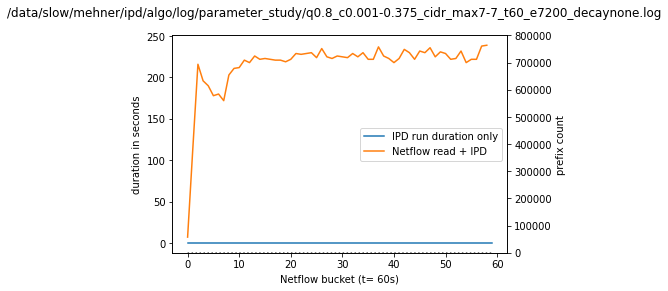

currently 55.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 229.92727272727274s; min: 7s; max: 251s


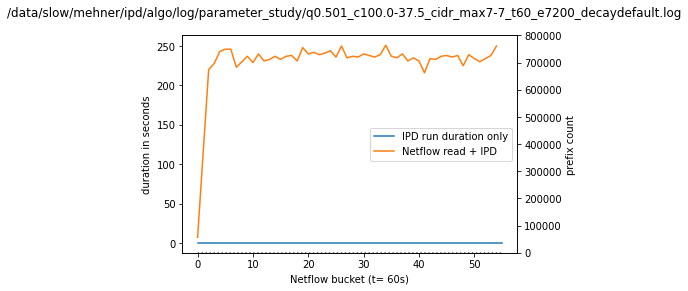

Caution: 2023-02-23 20:39:59.566000 -> 2023-02-23 20:50:35.440000: netflow ts: 1605558300 iteration run took extremly long: 0:10:35.874000
Caution: 2023-02-23 20:50:35.440000 -> 2023-02-23 21:04:50.018000: netflow ts: 1605558360 iteration run took extremly long: 0:14:14.578000
Caution: 2023-02-23 21:04:50.018000 -> 2023-02-23 21:27:30.733000: netflow ts: 1605558420 iteration run took extremly long: 0:22:40.715000
Caution: 2023-02-23 21:27:30.733000 -> 2023-02-23 21:57:48.076000: netflow ts: 1605558480 iteration run took extremly long: 0:30:17.343000
currently 29.0 minutes done
IPD run: avg: 299.3666666666667s; min: 0; max: 5668
iteration run: avg: 449.37931034482756s; min: 9s; max: 1817s


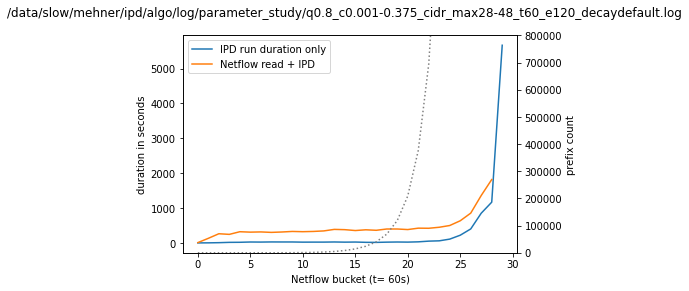

currently 60.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 213.6s; min: 8s; max: 249s


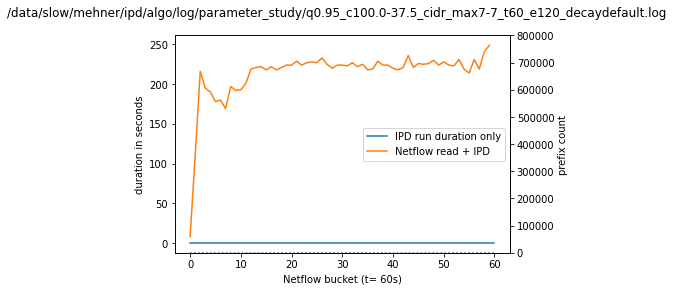

currently 42.0 minutes done
IPD run: avg: 14.534883720930232s; min: 0; max: 43
iteration run: avg: 302.8809523809524s; min: 9s; max: 396s


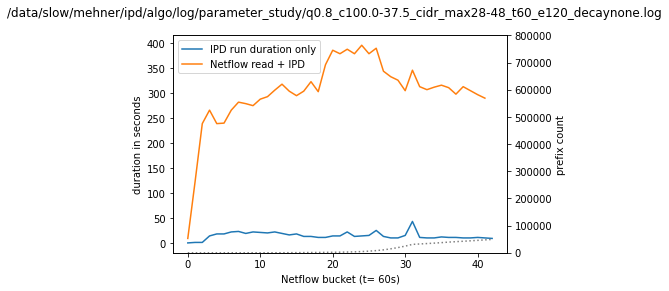

currently 41.0 minutes done
IPD run: avg: 23.595238095238095s; min: 0; max: 115
iteration run: avg: 306.7073170731707s; min: 8s; max: 420s


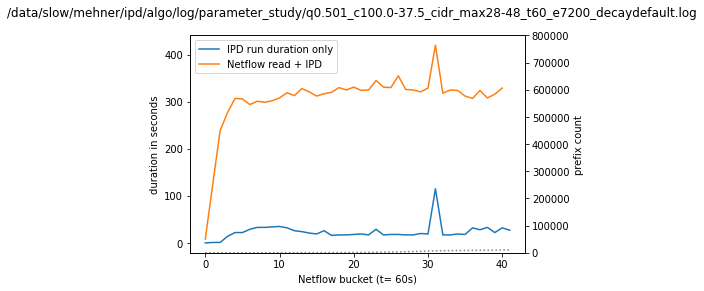

currently 36.0 minutes done
IPD run: avg: 28.513513513513512s; min: 0; max: 74
iteration run: avg: 351.47222222222223s; min: 9s; max: 414s


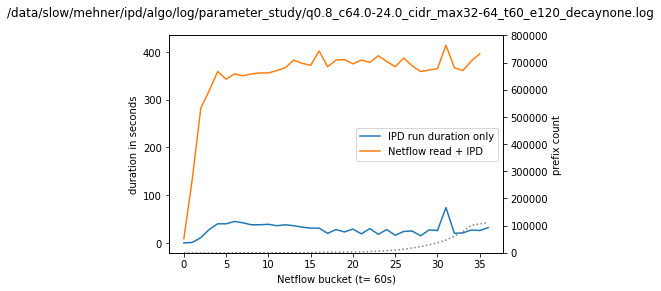

currently 42.0 minutes done
IPD run: avg: 14.209302325581396s; min: 0; max: 45
iteration run: avg: 303.07142857142856s; min: 8s; max: 356s


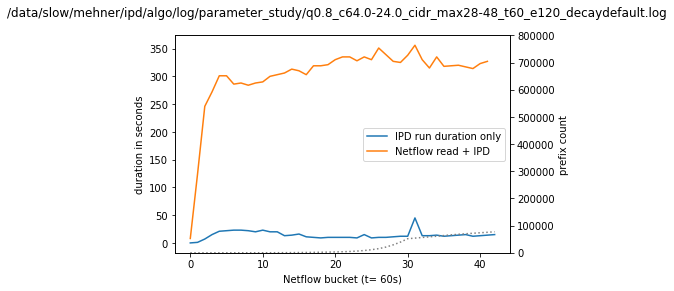

currently 58.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 218.58620689655172s; min: 8s; max: 245s


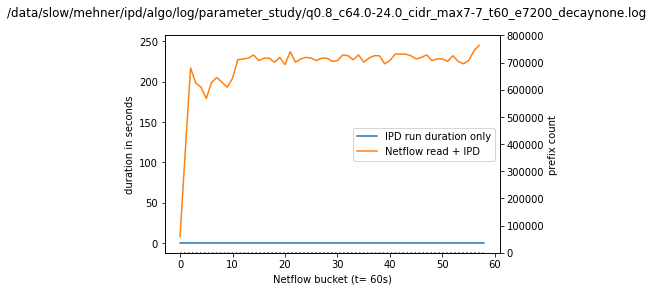

currently 56.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 225.89285714285714s; min: 8s; max: 250s


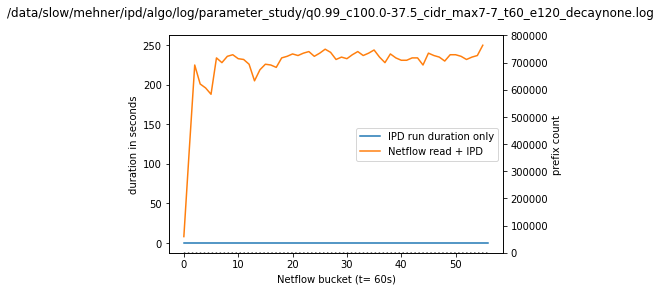

currently 35.0 minutes done
IPD run: avg: 38.5s; min: 0; max: 79
iteration run: avg: 360.9714285714286s; min: 8s; max: 447s


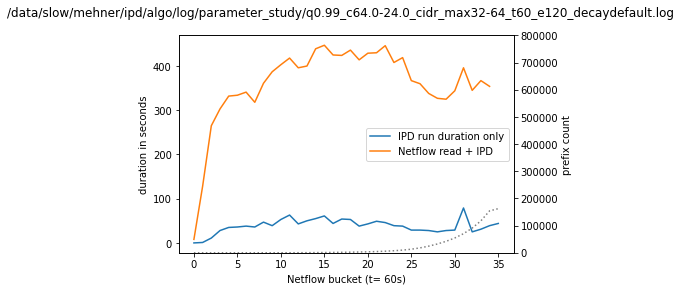

currently 41.0 minutes done
IPD run: avg: 23.142857142857142s; min: 0; max: 91
iteration run: avg: 309.0243902439024s; min: 7s; max: 399s


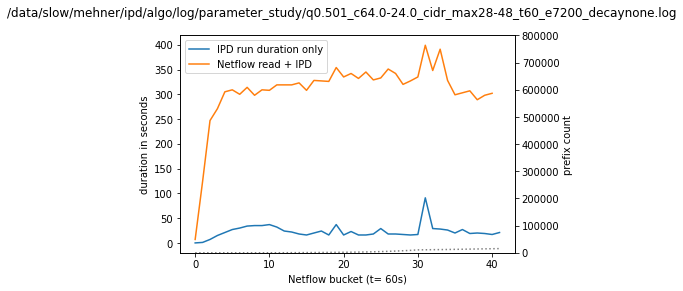

Caution: 2023-02-23 20:51:14.963000 -> 2023-02-23 21:02:09.708000: netflow ts: 1605558300 iteration run took extremly long: 0:10:54.745000
Caution: 2023-02-23 21:02:09.708000 -> 2023-02-23 21:18:26.722000: netflow ts: 1605558360 iteration run took extremly long: 0:16:17.014000
Caution: 2023-02-23 21:18:26.722000 -> 2023-02-23 21:44:09.813000: netflow ts: 1605558420 iteration run took extremly long: 0:25:43.091000
currently 28.0 minutes done
IPD run: avg: 140.41379310344828s; min: 0; max: 1147
iteration run: avg: 436.2142857142857s; min: 9s; max: 1543s


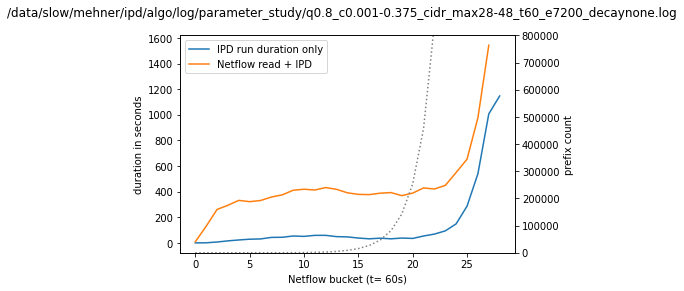

Caution: 2023-02-23 21:27:31.479000 -> 2023-02-23 21:37:50.333000: netflow ts: 1605558840 iteration run took extremly long: 0:10:18.854000
Caution: 2023-02-23 21:37:50.333000 -> 2023-02-23 21:48:50.110000: netflow ts: 1605558900 iteration run took extremly long: 0:10:59.777000
currently 36.0 minutes done
IPD run: avg: 56.486486486486484s; min: 0; max: 276
iteration run: avg: 346.9166666666667s; min: 9s; max: 659s


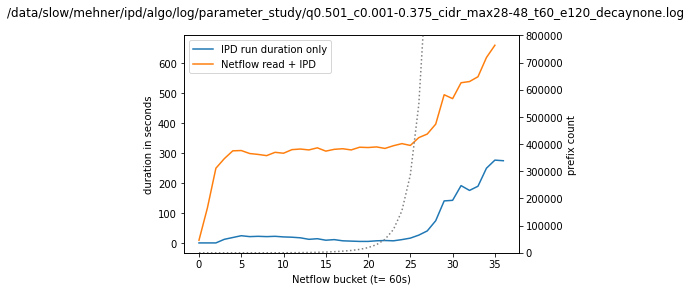

Caution: 2023-02-23 20:42:05.292000 -> 2023-02-23 20:55:24.135000: netflow ts: 1605558300 iteration run took extremly long: 0:13:18.843000
Caution: 2023-02-23 20:55:24.135000 -> 2023-02-23 21:16:03.453000: netflow ts: 1605558360 iteration run took extremly long: 0:20:39.318000
Caution: 2023-02-23 21:16:03.453000 -> 2023-02-23 21:53:53.089000: netflow ts: 1605558420 iteration run took extremly long: 0:37:49.636000
currently 28.0 minutes done
IPD run: avg: 373.62068965517244s; min: 0; max: 7105
iteration run: avg: 457.0357142857143s; min: 8s; max: 2269s


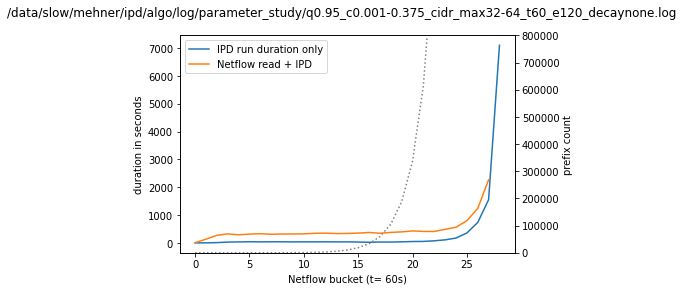

currently 57.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 222.96491228070175s; min: 8s; max: 246s


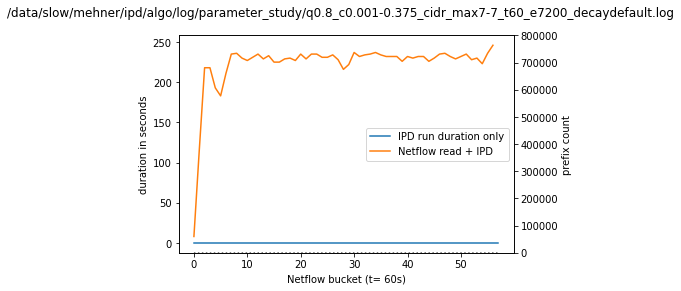

currently 42.0 minutes done
IPD run: avg: 15.813953488372093s; min: 0; max: 53
iteration run: avg: 306.04761904761904s; min: 9s; max: 391s


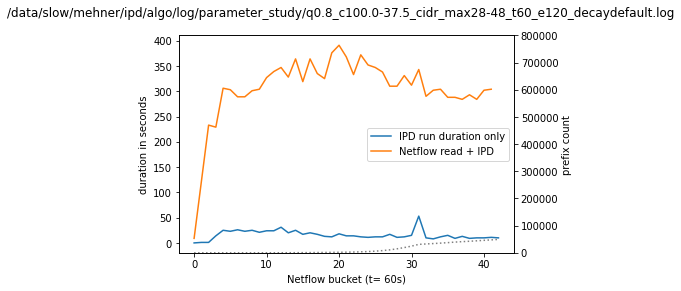

currently 36.0 minutes done
IPD run: avg: 37.75675675675676s; min: 0; max: 77
iteration run: avg: 350.5833333333333s; min: 8s; max: 440s


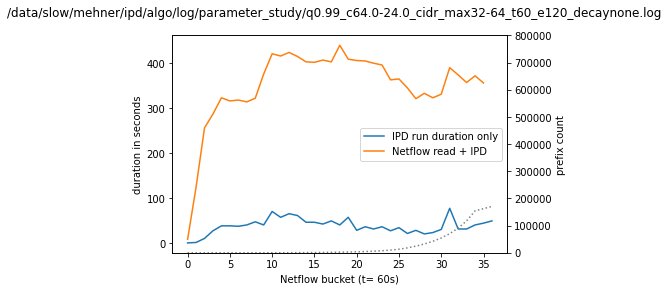

currently 39.0 minutes done
IPD run: avg: 30.6s; min: 0; max: 72
iteration run: avg: 326.20512820512823s; min: 9s; max: 443s


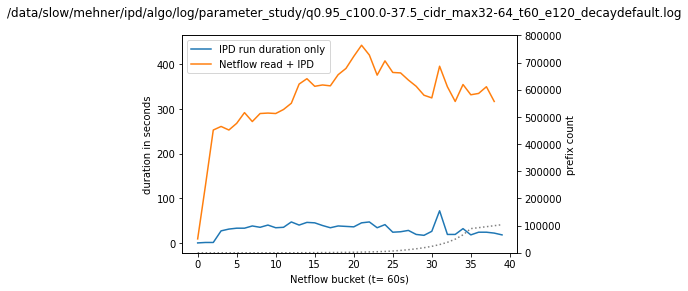

currently 56.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 229.21428571428572s; min: 9s; max: 258s


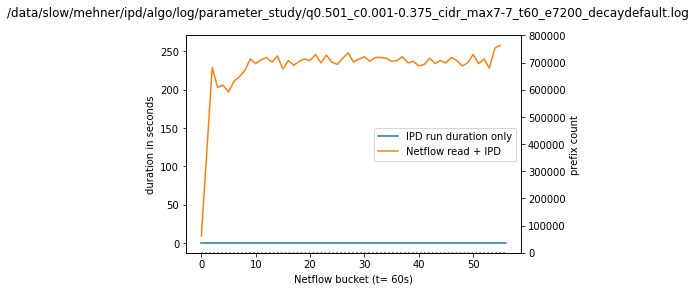

currently 40.0 minutes done
IPD run: avg: 16.26829268292683s; min: 0; max: 40
iteration run: avg: 317.675s; min: 8s; max: 405s


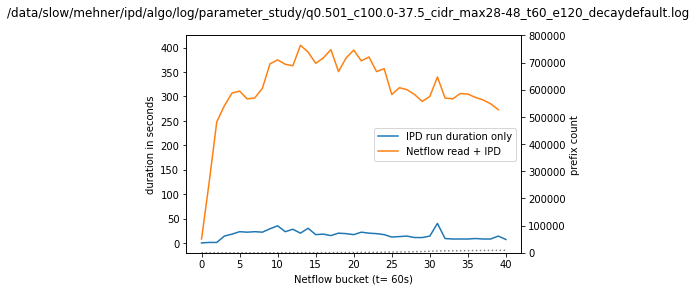

Caution: 2023-02-23 21:14:06.557000 -> 2023-02-23 21:24:48.946000: netflow ts: 1605558660 iteration run took extremly long: 0:10:42.389000
Caution: 2023-02-23 21:24:48.946000 -> 2023-02-23 21:36:37.047000: netflow ts: 1605558720 iteration run took extremly long: 0:11:48.101000
Caution: 2023-02-23 21:36:37.047000 -> 2023-02-23 21:47:47.434000: netflow ts: 1605558780 iteration run took extremly long: 0:11:10.387000
currently 34.0 minutes done
IPD run: avg: 59.542857142857144s; min: 0; max: 292
iteration run: avg: 365.47058823529414s; min: 8s; max: 708s


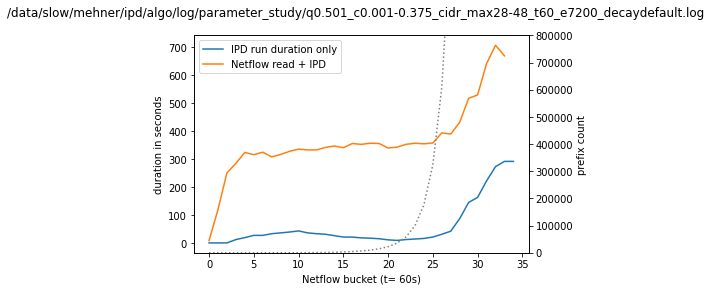

currently 42.0 minutes done
IPD run: avg: 22.348837209302324s; min: 0; max: 48
iteration run: avg: 303.57142857142856s; min: 8s; max: 383s


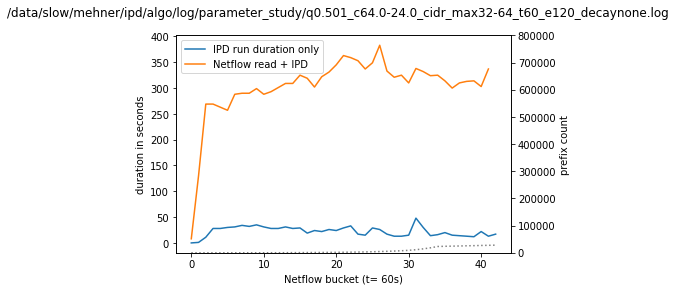

currently 57.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 224.47368421052633s; min: 8s; max: 262s


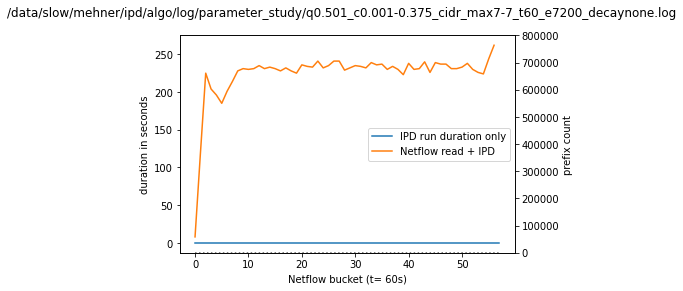

currently 59.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 217.47457627118644s; min: 8s; max: 247s


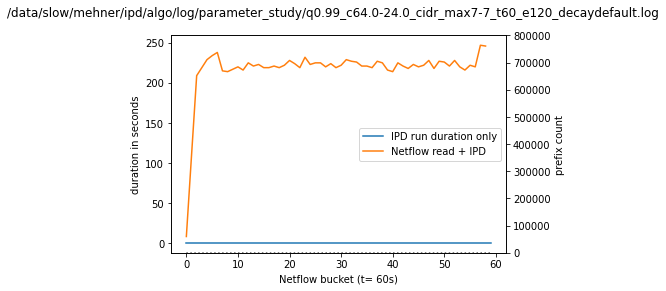

Caution: 2023-02-23 21:03:12.274000 -> 2023-02-23 21:13:59.921000: netflow ts: 1605558600 iteration run took extremly long: 0:10:47.647000
Caution: 2023-02-23 21:13:59.921000 -> 2023-02-23 21:32:22.981000: netflow ts: 1605558660 iteration run took extremly long: 0:18:23.060000
currently 32.0 minutes done
IPD run: avg: 95.81818181818181s; min: 0; max: 1371
iteration run: avg: 359.53125s; min: 9s; max: 1103s


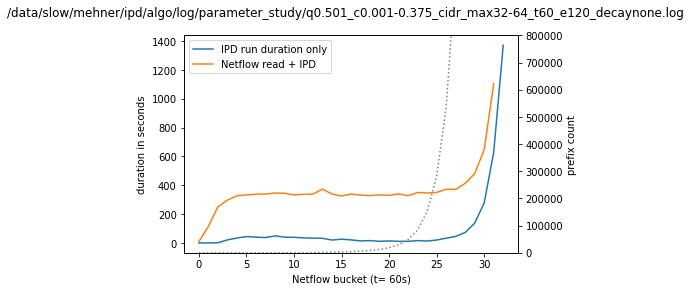

currently 60.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 214.51666666666668s; min: 8s; max: 239s


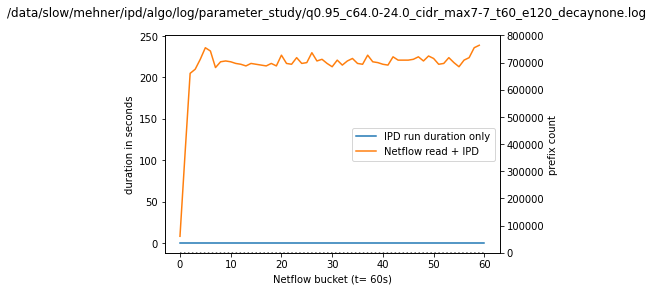

currently 40.0 minutes done
IPD run: avg: 16.829268292682926s; min: 0; max: 47
iteration run: avg: 318.05s; min: 8s; max: 395s


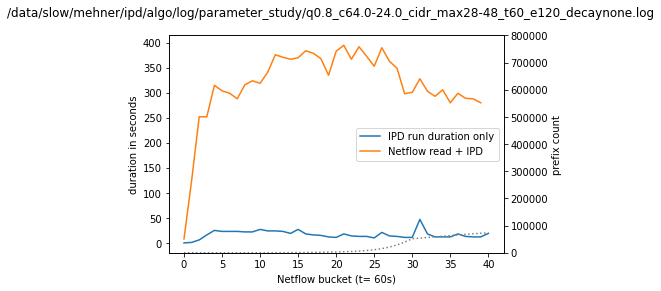

currently 61.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 207.70491803278688s; min: 7s; max: 227s


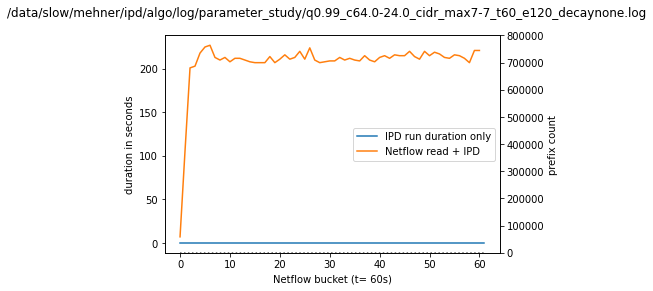

currently 38.0 minutes done
IPD run: avg: 28.46153846153846s; min: 0; max: 77
iteration run: avg: 334.4736842105263s; min: 9s; max: 402s


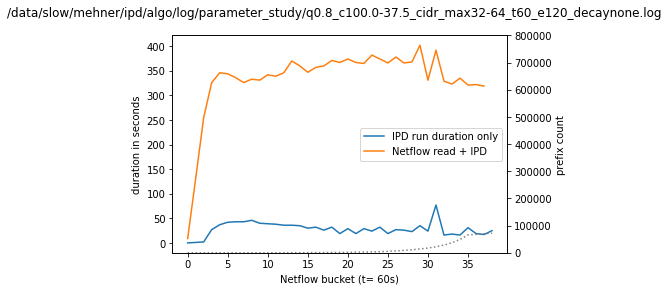

currently 43.0 minutes done
IPD run: avg: 12.159090909090908s; min: 0; max: 33
iteration run: avg: 299.0232558139535s; min: 8s; max: 345s


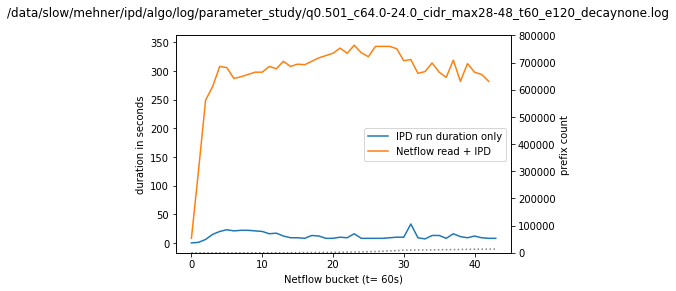

currently 58.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 221.70689655172413s; min: 8s; max: 252s


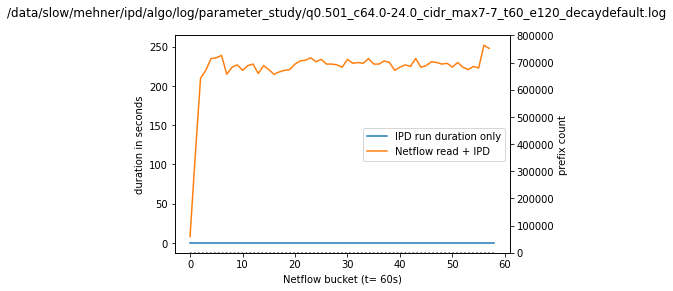

Caution: 2023-02-23 20:38:40.524000 -> 2023-02-23 20:50:33.484000: netflow ts: 1605558300 iteration run took extremly long: 0:11:52.960000
Caution: 2023-02-23 20:50:33.484000 -> 2023-02-23 21:09:07.986000: netflow ts: 1605558360 iteration run took extremly long: 0:18:34.502000
Caution: 2023-02-23 21:09:07.986000 -> 2023-02-23 21:44:11.546000: netflow ts: 1605558420 iteration run took extremly long: 0:35:03.560000
currently 28.0 minutes done
IPD run: avg: 380.2068965517241s; min: 0; max: 7571
iteration run: avg: 436.14285714285717s; min: 9s; max: 2103s


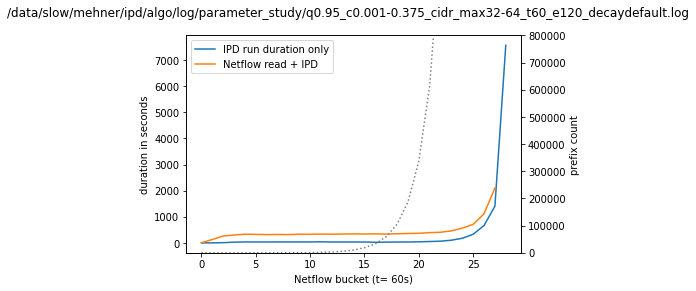

currently 58.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 221.1551724137931s; min: 8s; max: 252s


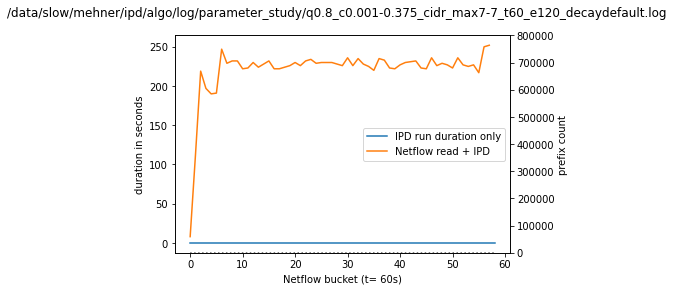

Caution: 2023-02-23 20:55:24.896000 -> 2023-02-23 21:06:21.146000: netflow ts: 1605558300 iteration run took extremly long: 0:10:56.250000
Caution: 2023-02-23 21:06:21.146000 -> 2023-02-23 21:21:52.425000: netflow ts: 1605558360 iteration run took extremly long: 0:15:31.279000
Caution: 2023-02-23 21:21:52.425000 -> 2023-02-23 21:47:31.607000: netflow ts: 1605558420 iteration run took extremly long: 0:25:39.182000
currently 28.0 minutes done
IPD run: avg: 339.2413793103448s; min: 0; max: 6551
iteration run: avg: 443.4642857142857s; min: 9s; max: 1539s


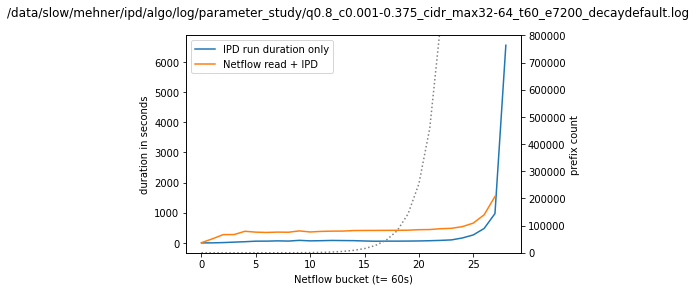

Caution: 2023-02-23 20:44:39.191000 -> 2023-02-23 20:57:38.927000: netflow ts: 1605558300 iteration run took extremly long: 0:12:59.736000
Caution: 2023-02-23 20:57:38.927000 -> 2023-02-23 21:17:21.287000: netflow ts: 1605558360 iteration run took extremly long: 0:19:42.360000
Caution: 2023-02-23 21:17:21.287000 -> 2023-02-23 21:53:02.159000: netflow ts: 1605558420 iteration run took extremly long: 0:35:40.872000
currently 28.0 minutes done
IPD run: avg: 346.6896551724138s; min: 0; max: 6533
iteration run: avg: 455.2142857142857s; min: 8s; max: 2140s


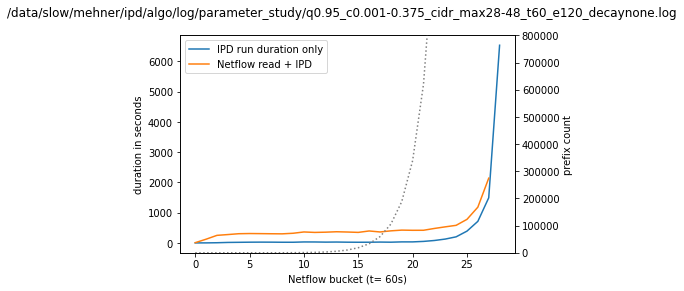

currently 60.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 211.75s; min: 7s; max: 234s


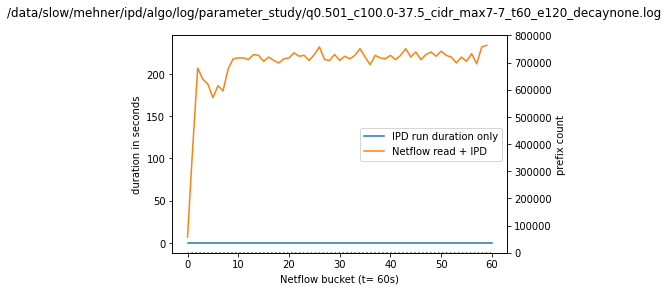

currently 40.0 minutes done
IPD run: avg: 17.390243902439025s; min: 0; max: 51
iteration run: avg: 319.975s; min: 9s; max: 413s


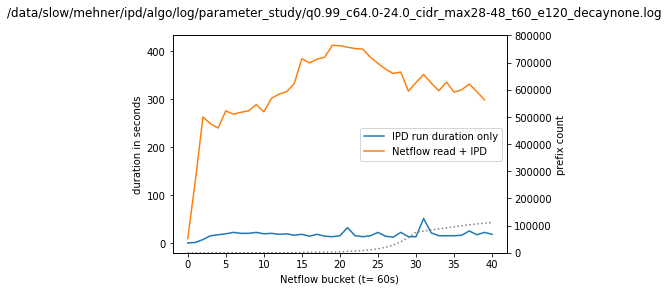

currently 58.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 221.9655172413793s; min: 8s; max: 249s


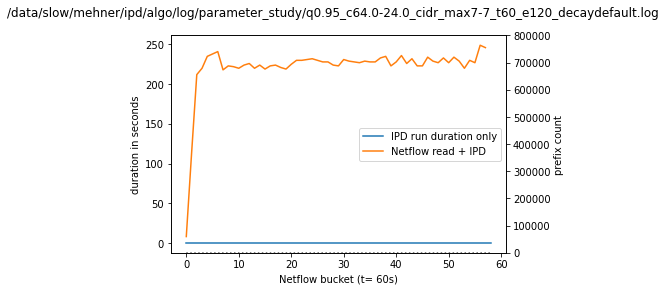

currently 38.0 minutes done
IPD run: avg: 27.512820512820515s; min: 0; max: 52
iteration run: avg: 335.36842105263156s; min: 9s; max: 403s


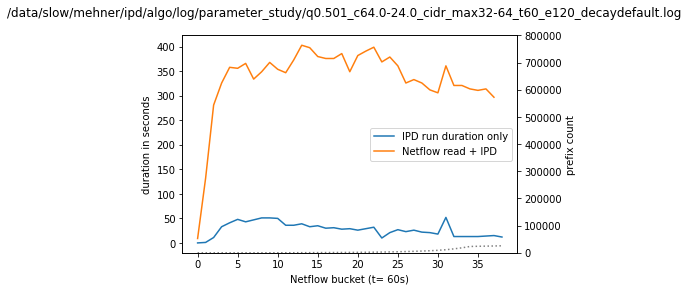

currently 57.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 222.859649122807s; min: 8s; max: 246s


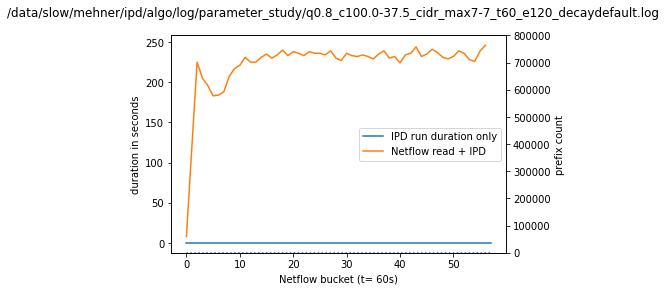

currently 38.0 minutes done
IPD run: avg: 36.02564102564103s; min: 0; max: 80
iteration run: avg: 332.44736842105266s; min: 8s; max: 391s


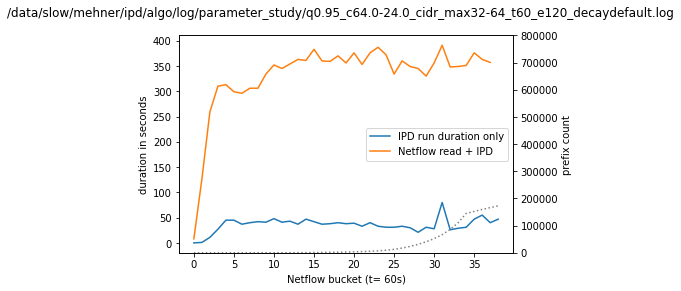

In [1]:
import datetime
from sys import prefix
import matplotlib.pyplot as plt
import  glob
import numpy as np



### data stuff

format = "%Y-%m-%d %H:%M:%S,%f"

for logfile in glob.glob("/data/slow/mehner/ipd/algo/log/parameter_study/*"):
    try:
        file = open(logfile, 'r')
        Lines = file.readlines()

        count=0
        last_start_ts=None
        start_ts=None
        end_ts=None

        ipd_run_list=[]
        iteration_run_list=[]
        prefix_list=[]
        for line in Lines:
            count += 1
            # print("Line{}: {}".format(count, line.strip()))
            x = line.split(" ")

            ts=datetime.datetime.strptime(f"{x[0]} {x[1]}", format)
            #print(ts)
            if last_start_ts == None:   last_start_ts = ts
            if "run IPD" in line:
                start_ts=ts
                try:
                    prefix_list.append(int(x[-2]))
                except:
                    pass

                if last_start_ts != start_ts:
                    iteration_duration= start_ts- last_start_ts
                    if int(iteration_duration.seconds) > 600:
                        #print(x)
                        print(f"Caution: {last_start_ts} -> {start_ts}: netflow ts: {int(x[-5])} iteration run took extremly long: {iteration_duration}")
                    iteration_run_list.append(iteration_duration.seconds)
                    last_start_ts = start_ts
                
            elif "Finished" in line:
                end_ts=ts
                duration = end_ts - start_ts
                ipd_run_list.append(duration.seconds)

        ## plotting stuff
        # get t
        t = int(logfile.split("_t")[1].split("_e")[0])/60
        

        fig,ax = plt.subplots()
        ax.plot(ipd_run_list, label="IPD run duration only")
        ax.plot(iteration_run_list, label="Netflow read + IPD")
        # ax.set_xticklabels(np.arange(0, 1560, t))

        ax.set_xlabel(f"Netflow bucket (t= {int(t*60)}s)")
        ax.set_ylabel("duration in seconds")
        # ax.set_ylim(0, 500)
        # ax.set_xlim(0, 1560/t)
        
        plt.legend()

        ax2=ax.twinx()
        ax2.plot(prefix_list, label="prefix count", linestyle="dotted", color="grey")
        ax2.set_ylabel("prefix count")
        ax2.set_ylim(0, 800000)


        plt.suptitle(f"{logfile}")

        print(f"currently {len(iteration_run_list)*t} minutes done")
        print(f"IPD run: avg: {sum(ipd_run_list) / len(ipd_run_list)}s; min: {min(ipd_run_list)}; max: {max(ipd_run_list)}")
        print(f"iteration run: avg: {sum(iteration_run_list) / len(iteration_run_list)}s; min: {min(iteration_run_list)}s; max: {max(iteration_run_list)}s")
        plt.show()
    except: pass
